In [1]:
import sys
print(sys.executable)

c:\Users\Admin\.conda\envs\lungscv\python.exe


In [2]:
!python --version

Python 3.8.19


In [ ]:
import pandas as pd
import numpy as np

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import OrdinalEncoder, normalize
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope


RANDOM_STATE = 42
FOLD_NUMBER = 2


def load_data(path):
    data = pd.read_csv(path)
    return data

df = load_data('Data\\churn.csv')
df.head()


'''
columns name
account_length	number_vmail_messages	total_day_minutes	total_day_calls	total_day_charge	total_eve_minutes	total_eve_calls	total_eve_charge	total_night_minutes	total_night_calls	total_night_charge	total_intl_minutes	total_intl_calls	total_intl_charge	number_customer_service_calls
'''
def data_cleaning(data):
    print("na values available in data \n")
    print(data.isna().sum())
    data = data.dropna()
    print("after droping na values \n")
    print(data.isna().sum())
    return data

def preprocessing(df):
    df.area_code = df.area_code.map({'area_code_415':415,'area_code_408':408,'area_code_510':510})
    df = df.replace({'voice_mail_plan':{'yes':1,'no':0}})
    df = df.replace({'international_plan':{'yes':1,'no':0}})
    df = df.replace({'churn':{'yes':1,"no":0}})
    df.state = df.state.astype('category')
    col_drop = ['total_day_minutes','total_night_minutes','total_eve_minutes','total_intl_minutes']
    df = df.drop(columns = col_drop,axis = 1)
    return df
def train_test_split(final_data):
    from sklearn.model_selection import train_test_split
    X = final_data.drop(['state','churn'],axis = 1)
    y = final_data['churn']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=47)
    return X_train, X_test, y_train, y_test
def over_sampling_target_class(X_train, y_train):
    ### Over-sampling using SMOTE 
    from imblearn.over_sampling import SMOTE
    os = SMOTE(random_state=0)

    columns = X_train.columns
    os_data_X,os_data_y=os.fit_resample(X_train, y_train)

    os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
    os_data_y= pd.DataFrame(data=os_data_y,columns=['churn'])
    # we can Check the numbers of our data
    print("length of oversampled data is ",len(os_data_X))
    print("Number of no churn in oversampled data",len(os_data_y[os_data_y['churn']==0]))
    print("Number of churn",len(os_data_y[os_data_y['churn']==1]))
    print("Proportion of no churn data in oversampled data is ",len(os_data_y[os_data_y['churn']==0])/len(os_data_X))
    print("Proportion of churn data in oversampled data is ",len(os_data_y[os_data_y['churn']==1])/len(os_data_X))
    
    X_train = os_data_X
    y_train = os_data_y['churn']
 
    return X_train, y_train

def training_basic_classifier(X_train,y_train):
    from sklearn.ensemble import RandomForestClassifier
    model = RandomForestClassifier(n_estimators=101)
    model.fit(X_train, y_train)
    
    return model

def predict_prob_on_test_data(model,X_test):
    y_pred = model.predict_proba(X_test)
    return y_pred


def get_metrics(y_true, y_pred, y_pred_prob):
    from sklearn.metrics import accuracy_score,precision_score,recall_score,log_loss
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    entropy = log_loss(y_true, y_pred_prob)
    return {'accuracy': round(acc, 2), 'precision': round(prec, 2), 'recall': round(recall, 2), 'entropy': round(entropy, 2)}

: 

In [4]:
RANDOM_STATE = 42
FOLD_NUMBER = 2

In [5]:
def load_data(path):
    data = pd.read_csv(path)
    return data

df = load_data('Data\\churn.csv')
df.head()




,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
1,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
2,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
3,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no
4,MA,121,area_code_510,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,no


,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
count,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000
mean,100.236235,7.631765,180.259600,99.907294,30.644682,200.173906,100.176471,17.015012,200.527882,99.839529,9.023892,10.256071,4.426353,2.769654,1.559059
std,39.698401,13.439882,54.012373,19.850817,9.182096,50.249518,19.908591,4.271212,50.353548,20.093220,2.265922,2.760102,2.463069,0.745204,1.311434
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,73.000000,0.000000,143.325000,87.000000,24.365000,165.925000,87.000000,14.102500,167.225000,86.000000,7.522500,8.500000,3.000000,2.300000,1.000000
50%,100.000000,0.000000,180.450000,100.000000,30.680000,200.700000,100.000000,17.060000,200.450000,100.000000,9.020000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,16.000000,216.200000,113.000000,36.750000,233.775000,114.000000,19.867500,234.700000,113.000000,10.560000,12.000000,6.000000,3.240000,2.000000
max,243.000000,52.000000,351.500000,165.000000,59.760000,359.300000,170.000000,30.540000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4250 entries, 0 to 4249
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   state                          4250 non-null   object 
 1   account_length                 4250 non-null   int64  
 2   area_code                      4250 non-null   object 
 3   international_plan             4250 non-null   object 
 4   voice_mail_plan                4250 non-null   object 
 5   number_vmail_messages          4250 non-null   int64  
 6   total_day_minutes              4250 non-null   float64
 7   total_day_calls                4250 non-null   int64  
 8   total_day_charge               4250 non-null   float64
 9   total_eve_minutes              4250 non-null   float64
 10  total_eve_calls                4250 non-null   int64  
 11  total_eve_charge               4250 non-null   float64
 12  total_night_minutes            4250 non-null   f

In [8]:
df.area_code.unique()

array(['area_code_415', 'area_code_408', 'area_code_510'], dtype=object)

In [9]:
def data_cleaning(data):
    print("na values available in data \n")
    print(data.isna().sum())
    data = data.dropna()
    print("after droping na values \n")
    print(data.isna().sum())
    return data

In [10]:
def preprocessing(df):
    df.area_code = df.area_code.map({'area_code_415':415,'area_code_408':408,'area_code_510':510})
    df = df.replace({'voice_mail_plan':{'yes':1,'no':0}})
    df = df.replace({'international_plan':{'yes':1,'no':0}})
    df = df.replace({'churn':{'yes':1,"no":0}})
    df.state = df.state.astype('category')
    col_drop = ['total_day_minutes','total_night_minutes','total_eve_minutes','total_intl_minutes']
    df = df.drop(columns = col_drop,axis = 1)
    return df

In [11]:
def preprocessing(df):
    df.area_code = df.area_code.map({'area_code_415':415,'area_code_408':408,'area_code_510':510})
    df = df.replace({'voice_mail_plan':{'yes':1,'no':0}})
    df = df.replace({'international_plan':{'yes':1,'no':0}})
    df = df.replace({'churn':{'yes':1,"no":0}})
    df.state = df.state.astype('category')
    col_drop = ['total_day_minutes','total_night_minutes','total_eve_minutes','total_intl_minutes']
    df = df.drop(columns = col_drop,axis = 1)
    return df
def train_test_split(final_data):
    from sklearn.model_selection import train_test_split
    X = final_data.drop(['state','churn'],axis = 1)
    y = final_data['churn']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=47)
    return X_train, X_test, y_train, y_test
def over_sampling_target_class(X_train, y_train):
    ### Over-sampling using SMOTE 
    from imblearn.over_sampling import SMOTE
    os = SMOTE(random_state=0)

    columns = X_train.columns
    os_data_X,os_data_y=os.fit_resample(X_train, y_train)

    os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
    os_data_y= pd.DataFrame(data=os_data_y,columns=['churn'])
    # we can Check the numbers of our data
    print("length of oversampled data is ",len(os_data_X))
    print("Number of no churn in oversampled data",len(os_data_y[os_data_y['churn']==0]))
    print("Number of churn",len(os_data_y[os_data_y['churn']==1]))
    print("Proportion of no churn data in oversampled data is ",len(os_data_y[os_data_y['churn']==0])/len(os_data_X))
    print("Proportion of churn data in oversampled data is ",len(os_data_y[os_data_y['churn']==1])/len(os_data_X))
    
    X_train = os_data_X
    y_train = os_data_y['churn']
 
    return X_train, y_train

def training_basic_classifier(X_train,y_train):
    from sklearn.ensemble import RandomForestClassifier
    model = RandomForestClassifier(n_estimators=101)
    model.fit(X_train, y_train)
    
    return model

def predict_prob_on_test_data(model,X_test):
    y_pred = model.predict_proba(X_test)
    return y_pred


def get_metrics(y_true, y_pred, y_pred_prob):
    from sklearn.metrics import accuracy_score,precision_score,recall_score,log_loss
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    entropy = log_loss(y_true, y_pred_prob)
    return {'accuracy': round(acc, 2), 'precision': round(prec, 2), 'recall': round(recall, 2), 'entropy': round(entropy, 2)}

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def create_roc_auc_plot(clf, X_data, y_data):
    # Calculate predicted probabilities
    y_scores = clf.predict_proba(X_data)[:, 1]
    
    # Calculate fpr, tpr, thresholds
    fpr, tpr, thresholds = roc_curve(y_data, y_scores)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.savefig('roc_auc_curve.png')




import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def create_confusion_matrix_plot(clf, X_test, y_test):
    # Predict labels
    y_pred = clf.predict(X_test)
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    classes = np.unique(y_test)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')


def training_basic_classifier(X_train,y_train):
    from sklearn.ensemble import RandomForestClassifier
    model = RandomForestClassifier(n_estimators=101)
    model.fit(X_train, y_train)
    
    return model

def predict_prob_on_test_data(model,X_test):
    y_pred = model.predict_proba(X_test)
    return y_pred


def get_metrics(y_true, y_pred, y_pred_prob):
    from sklearn.metrics import accuracy_score,precision_score,recall_score,log_loss
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    entropy = log_loss(y_true, y_pred_prob)
    return {'accuracy': round(acc, 2), 'precision': round(prec, 2), 'recall': round(recall, 2), 'entropy': round(entropy, 2)}

In [12]:
def over_sampling_target_class(X_train, y_train):
    ### Over-sampling using SMOTE 
    from imblearn.over_sampling import SMOTE
    os = SMOTE(random_state=0)

    columns = X_train.columns
    os_data_X,os_data_y=os.fit_resample(X_train, y_train)

    os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
    os_data_y= pd.DataFrame(data=os_data_y,columns=['churn'])
    # we can Check the numbers of our data
    print("length of oversampled data is ",len(os_data_X))
    print("Number of no churn in oversampled data",len(os_data_y[os_data_y['churn']==0]))
    print("Number of churn",len(os_data_y[os_data_y['churn']==1]))
    print("Proportion of no churn data in oversampled data is ",len(os_data_y[os_data_y['churn']==0])/len(os_data_X))
    print("Proportion of churn data in oversampled data is ",len(os_data_y[os_data_y['churn']==1])/len(os_data_X))
    
    X_train = os_data_X
    y_train = os_data_y['churn']
 
    return X_train, y_train

In [13]:
def training_basic_classifier(X_train,y_train):
    from sklearn.ensemble import RandomForestClassifier
    model = RandomForestClassifier(n_estimators=101)
    model.fit(X_train, y_train)
    
    return model

def predict_prob_on_test_data(model,X_test):
    y_pred = model.predict_proba(X_test)
    return y_pred


def get_metrics(y_true, y_pred, y_pred_prob):
    from sklearn.metrics import accuracy_score,precision_score,recall_score,log_loss
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    entropy = log_loss(y_true, y_pred_prob)
    return {'accuracy': round(acc, 2), 'precision': round(prec, 2), 'recall': round(recall, 2), 'entropy': round(entropy, 2)}

In [14]:
def predict_on_test_data(model,X_test):
    y_pred = model.predict(X_test)
    return y_pred

In [15]:
def predict_prob_on_test_data(model,X_test):
    y_pred = model.predict_proba(X_test)
    return y_pred


def get_metrics(y_true, y_pred, y_pred_prob):
    from sklearn.metrics import accuracy_score,precision_score,recall_score,log_loss
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    entropy = log_loss(y_true, y_pred_prob)
    return {'accuracy': round(acc, 2), 'precision': round(prec, 2), 'recall': round(recall, 2), 'entropy': round(entropy, 2)}

In [16]:

def get_metrics(y_true, y_pred, y_pred_prob):
    from sklearn.metrics import accuracy_score,precision_score,recall_score,log_loss
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    entropy = log_loss(y_true, y_pred_prob)
    return {'accuracy': round(acc, 2), 'precision': round(prec, 2), 'recall': round(recall, 2), 'entropy': round(entropy, 2)}

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def create_roc_auc_plot(clf, X_data, y_data):
    # Calculate predicted probabilities
    y_scores = clf.predict_proba(X_data)[:, 1]
    
    # Calculate fpr, tpr, thresholds
    fpr, tpr, thresholds = roc_curve(y_data, y_scores)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.savefig('roc_auc_curve.png')


In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def create_roc_auc_plot(clf, X_data, y_data):
    # Calculate predicted probabilities
    y_scores = clf.predict_proba(X_data)[:, 1]
    
    # Calculate fpr, tpr, thresholds
    fpr, tpr, thresholds = roc_curve(y_data, y_scores)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.savefig('roc_auc_curve.png')




import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def create_confusion_matrix_plot(clf, X_test, y_test):
    # Predict labels
    y_pred = clf.predict(X_test)
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    classes = np.unique(y_test)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')


def training_basic_classifier(X_train,y_train):
    from sklearn.ensemble import RandomForestClassifier
    model = RandomForestClassifier(n_estimators=101)
    model.fit(X_train, y_train)
    
    return model

def predict_prob_on_test_data(model,X_test):
    y_pred = model.predict_proba(X_test)
    return y_pred


def get_metrics(y_true, y_pred, y_pred_prob):
    from sklearn.metrics import accuracy_score,precision_score,recall_score,log_loss
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    entropy = log_loss(y_true, y_pred_prob)
    return {'accuracy': round(acc, 2), 'precision': round(prec, 2), 'recall': round(recall, 2), 'entropy': round(entropy, 2)}

In [19]:
data = load_data('Data\\churn.csv')

cleaned_data = data_cleaning(data)

final_data = preprocessing(cleaned_data)

X_train, X_test, y_train, y_test = train_test_split(final_data)


X_train, y_train = over_sampling_target_class(X_train, y_train)

In [20]:
cleaned_data = data_cleaning(data)

na values available in data 

state                            0
account_length                   0
area_code                        0
international_plan               0
voice_mail_plan                  0
number_vmail_messages            0
total_day_minutes                0
total_day_calls                  0
total_day_charge                 0
total_eve_minutes                0
total_eve_calls                  0
total_eve_charge                 0
total_night_minutes              0
total_night_calls                0
total_night_charge               0
total_intl_minutes               0
total_intl_calls                 0
total_intl_charge                0
number_customer_service_calls    0
churn                            0
dtype: int64
after droping na values 

state                            0
account_length                   0
area_code                        0
international_plan               0
voice_mail_plan                  0
number_vmail_messages            0
total_day_minutes    

In [21]:
final_data = preprocessing(cleaned_data)


In [22]:
final_data

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_calls,total_day_charge,total_eve_calls,total_eve_charge,total_night_calls,total_night_charge,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,OH,107,415,0,1,26,123,27.47,103,16.62,103,11.45,3,3.70,1,0
1,NJ,137,415,0,0,0,114,41.38,110,10.30,104,7.32,5,3.29,0,0
2,OH,84,408,1,0,0,71,50.90,88,5.26,89,8.86,7,1.78,2,0
3,OK,75,415,1,0,0,113,28.34,122,12.61,121,8.41,3,2.73,3,0
4,MA,121,510,0,1,24,88,37.09,108,29.62,118,9.57,7,2.03,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4245,MT,83,415,0,0,0,70,32.01,88,20.72,79,9.62,6,2.78,0,0
4246,WV,73,408,0,0,0,89,30.24,82,11.15,89,8.38,6,3.11,3,0
4247,NC,75,408,0,0,0,101,29.02,126,16.41,104,5.81,7,1.86,1,0
4248,HI,50,408,0,1,40,127,40.07,126,18.96,116,13.39,5,2.67,2,0


In [23]:
X_train, X_test, y_train, y_test = train_test_split(final_data)

In [24]:
X_train, y_train = over_sampling_target_class(X_train, y_train)

length of oversampled data is  5126
Number of no churn in oversampled data 2563
Number of churn 2563
Proportion of no churn data in oversampled data is  0.5
Proportion of churn data in oversampled data is  0.5


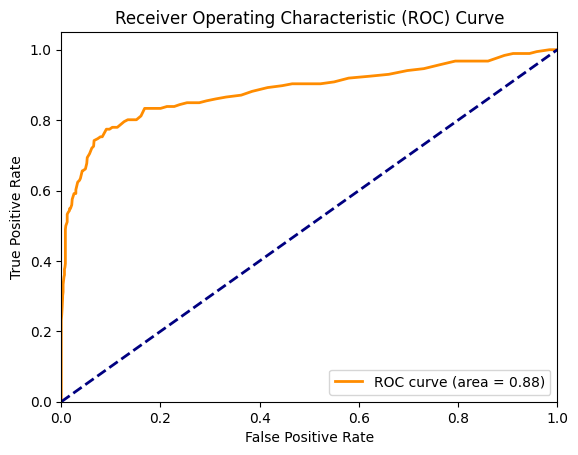

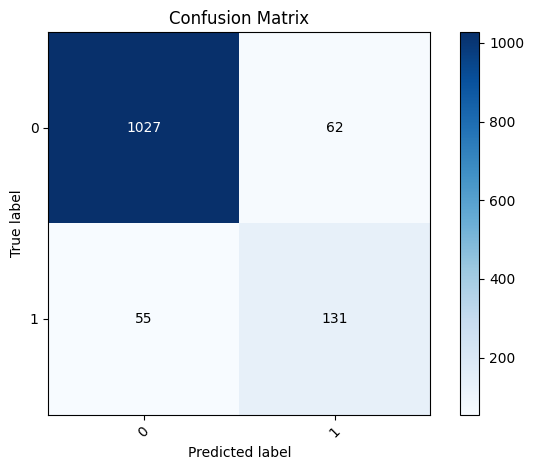

In [25]:
model = training_basic_classifier(X_train,y_train)
y_pred = predict_on_test_data(model,X_test)
y_pred_prob = predict_prob_on_test_data(model,X_test)
run_metrics = get_metrics(y_test, y_pred, y_pred_prob)
create_roc_auc_plot(model, X_test, y_test)
create_confusion_matrix_plot(model, X_test, y_test)


def create_experiment(experiment_name,run_name, run_metrics,model, confusion_matrix_path = None, 
                      roc_auc_plot_path = None, run_params=None):
    import mlflow
    #mlflow.set_tracking_uri("http://localhost:5000") #uncomment this line if you want to use any database like sqlite as backend storage for model
    mlflow.set_experiment(experiment_name)
    
    with mlflow.start_run():
        
        if not run_params == None:
            for param in run_params:
                mlflow.log_param(param, run_params[param])
            
        for metric in run_metrics:
            mlflow.log_metric(metric, run_metrics[metric])
        
        mlflow.sklearn.log_model(model, "model")
        
        if not confusion_matrix_path == None:
            mlflow.log_artifact(confusion_matrix_path, 'confusion_materix')
            
        if not roc_auc_plot_path == None:
            mlflow.log_artifact(roc_auc_plot_path, "roc_auc_plot")
        
        mlflow.set_tag("tag1", "Random Forest")
        mlflow.set_tags({"tag2":"Randomized Search CV", "tag3":"Production"})
            
    print('Run - %s is logged to Experiment - %s' %(run_name, experiment_name))
create_experiment(experiment_name,run_name,run_metrics,model,'confusion_matrix.png', 'roc_auc_curve.png')

experiment_name = "basic_classifier" ##basic classifier
run_name="first"
run_metrics = get_metrics(y_test, y_pred, y_pred_prob)
print(run_metrics)

In [26]:
run_metrics

{'accuracy': 0.91, 'precision': 0.68, 'recall': 0.7, 'entropy': 0.32}

MLFlow work Starts from here

In [27]:
experiment_name = "basic_classifier" ##basic classifier
run_name="first"
run_metrics = get_metrics(y_test, y_pred, y_pred_prob)
print(run_metrics)

{'accuracy': 0.91, 'precision': 0.68, 'recall': 0.7, 'entropy': 0.32}


In [28]:
def create_experiment(experiment_name,run_name, run_metrics,model, confusion_matrix_path = None, 
                      roc_auc_plot_path = None, run_params=None):
    import mlflow
    #mlflow.set_tracking_uri("http://localhost:5000") #uncomment this line if you want to use any database like sqlite as backend storage for model
    mlflow.set_experiment(experiment_name)
    
    with mlflow.start_run():
        
        if not run_params == None:
            for param in run_params:
                mlflow.log_param(param, run_params[param])
            
        for metric in run_metrics:
            mlflow.log_metric(metric, run_metrics[metric])
        
        mlflow.sklearn.log_model(model, "model")
        
        if not confusion_matrix_path == None:
            mlflow.log_artifact(confusion_matrix_path, 'confusion_materix')
            
        if not roc_auc_plot_path == None:
            mlflow.log_artifact(roc_auc_plot_path, "roc_auc_plot")
        
        mlflow.set_tag("tag1", "Random Forest")
        mlflow.set_tags({"tag2":"Randomized Search CV", "tag3":"Production"})
            
    print('Run - %s is logged to Experiment - %s' %(run_name, experiment_name))
create_experiment(experiment_name,run_name,run_metrics,model,'confusion_matrix.png', 'roc_auc_curve.png')

experiment_name = "basic_classifier" ##basic classifier
run_name="first"
run_metrics = get_metrics(y_test, y_pred, y_pred_prob)
print(run_metrics)

Run - term_deposit is logged to Experiment - basic_classifier


In [34]:
# Define the search space
search_space = {
    "n_estimators": hp.choice('n_estimators', [5, 21, 51, 101]),
    "max_features": hp.choice('max_features', [
    'sqrt',
    'log2',
    None,
    hp.uniform('max_features_frac', 0.1, 1.0)]),
    "max_depth": hp.choice('max_depth', [int(x) for x in np.linspace(10, 120, num=12)]),
    "min_samples_split": hp.choice('min_samples_split', [
    hp.quniform('min_samples_split_int', 2, 20, 1),
    hp.uniform('min_samples_split_float', 0.01, 0.5)
    ]),
    "min_samples_leaf": hp.choice('min_samples_leaf', [1, 3, 4]),
    "bootstrap": hp.choice('bootstrap', [True, False]),
    "criterion": hp.choice("criterion", ["gini", "entropy"]),
}

In [35]:
def objective(params):
    import mlflow
    with mlflow.start_run():
        mlflow.set_tag("model", "Hyperopt Tuned Random Forest")
        mlflow.log_params(params)
        
        model = RandomForestClassifier(**params)
        model.fit(X_train, y_train)
        y_pred = predict_on_test_data(model, X_test)
        y_pred_prob = predict_prob_on_test_data(model, X_test)
        run_metrics = get_metrics(y_test, y_pred, y_pred_prob)
        
        # Assuming these functions are defined correctly
        create_roc_auc_plot(model, X_test, y_test)
        create_confusion_matrix_plot(model, X_test, y_test)
        
        # Logging artifacts
        mlflow.log_artifact('confusion_matrix.png', 'confusion_matrix')
        mlflow.log_artifact('roc_auc_curve.png', 'roc_auc_plot')

        # Logging metrics
        for metric in run_metrics:
            mlflow.log_metric(metric, run_metrics[metric])
        
        # Return loss for hyperparameter optimization
        return {'loss': 1 - run_metrics['accuracy'], 'status': STATUS_OK}


  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 10/10 [00:23<00:00,  2.30s/trial, best loss: 0.07999999999999996]


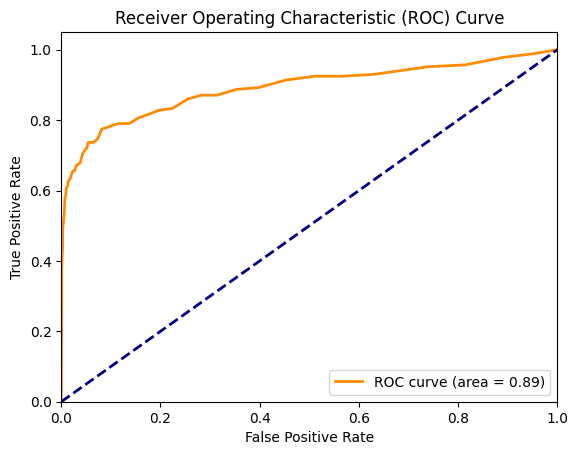

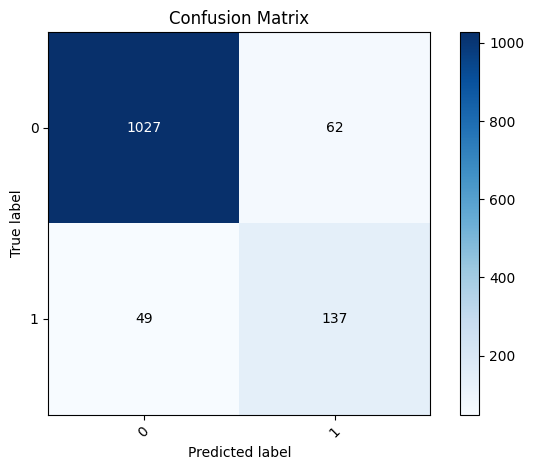

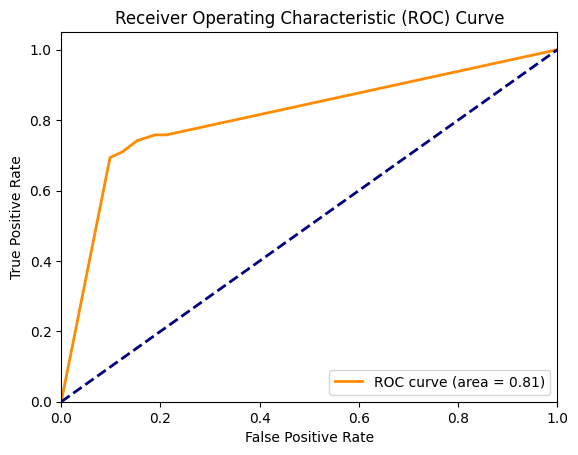

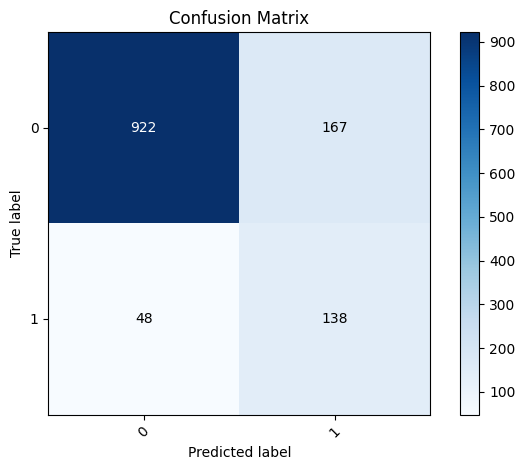

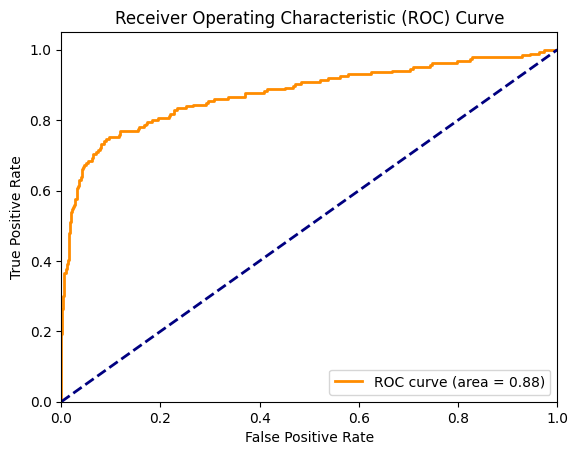

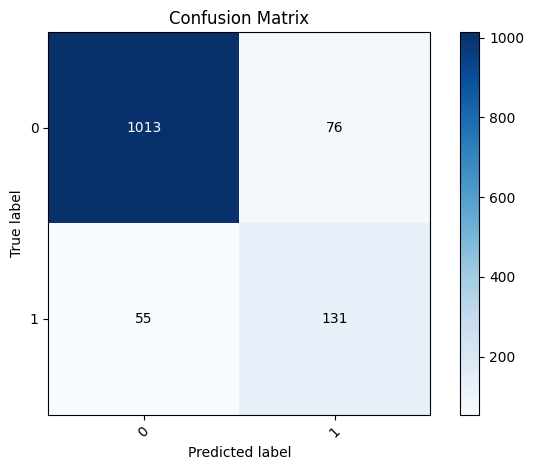

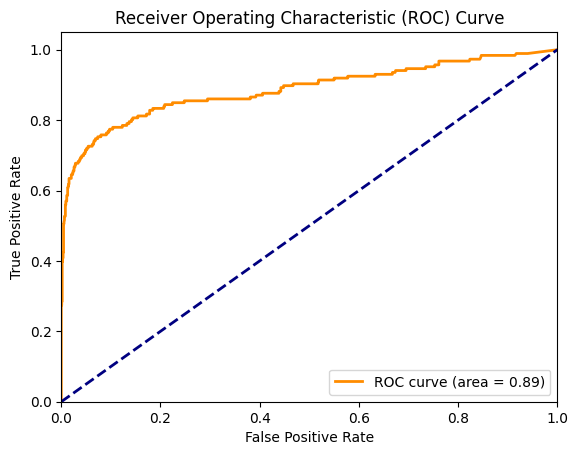

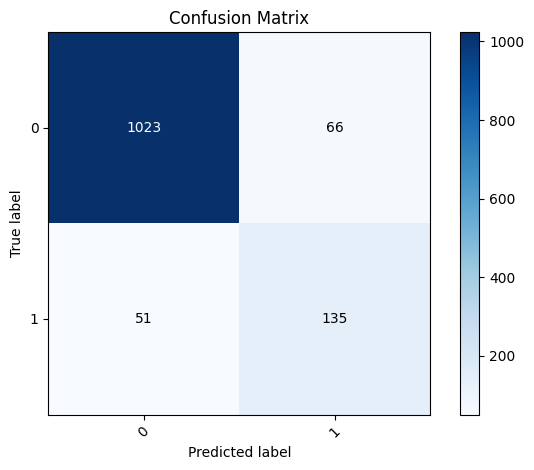

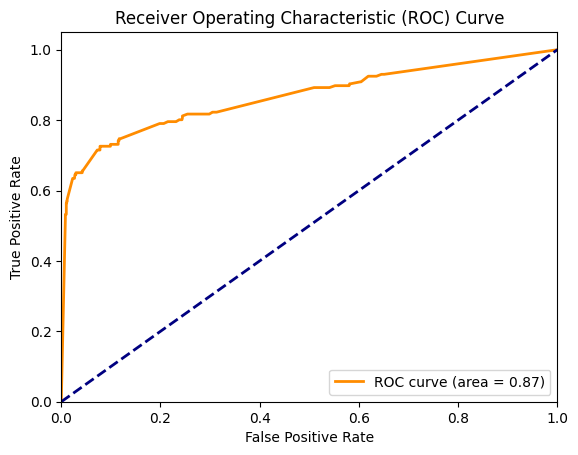

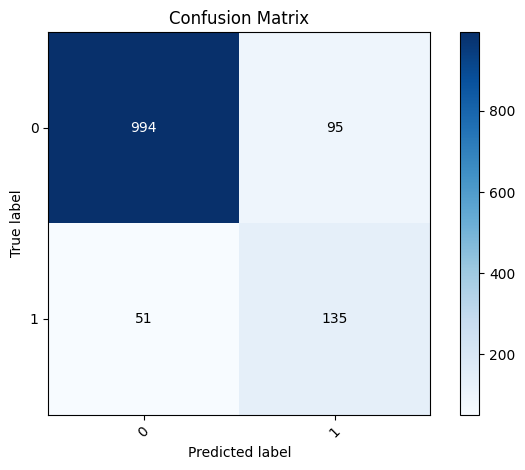

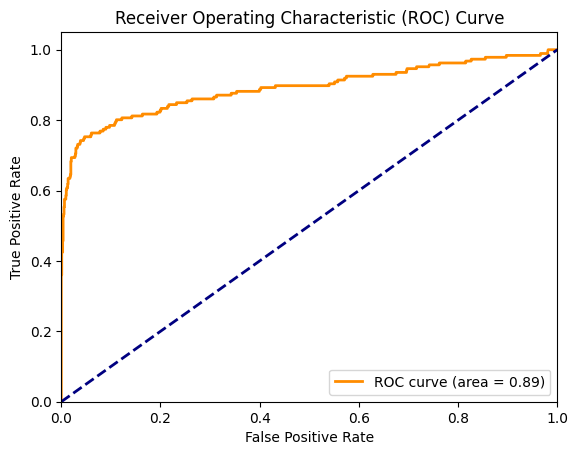

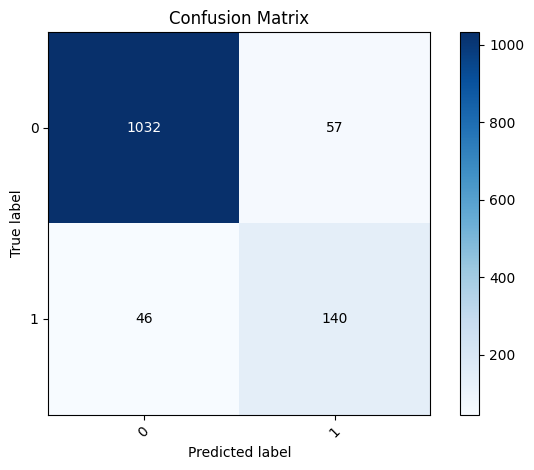

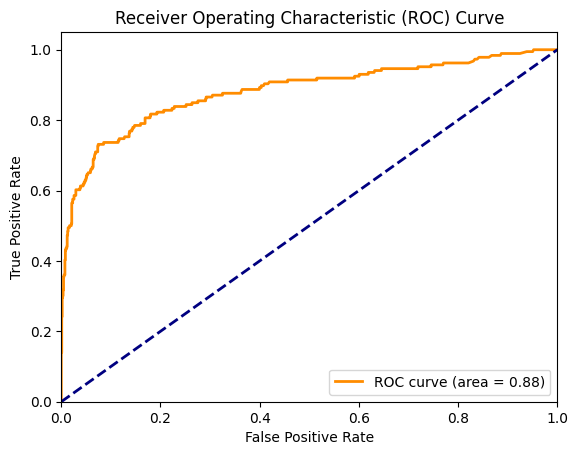

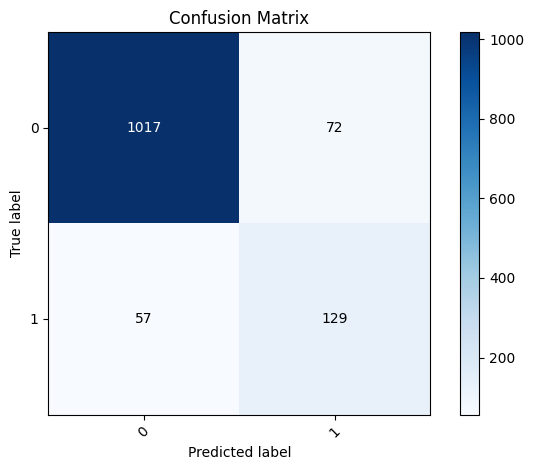

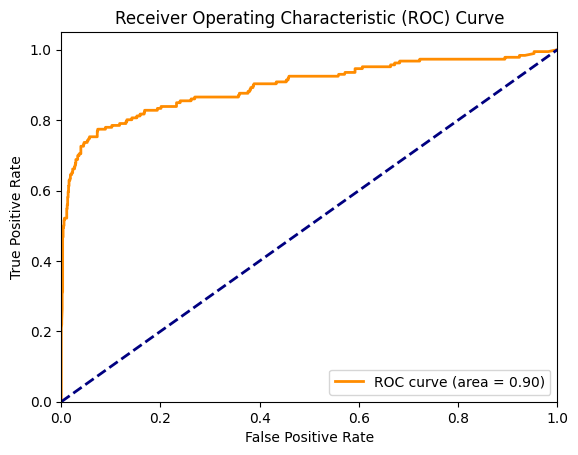

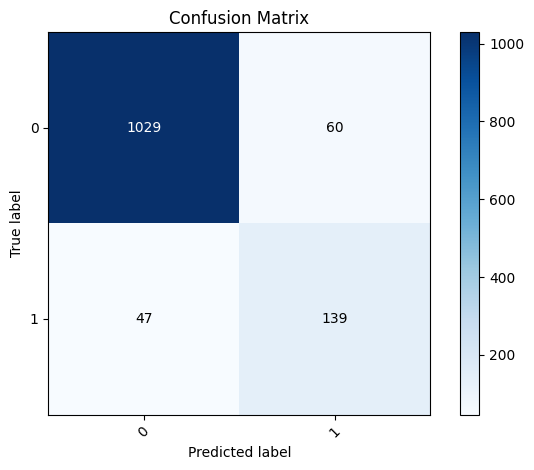

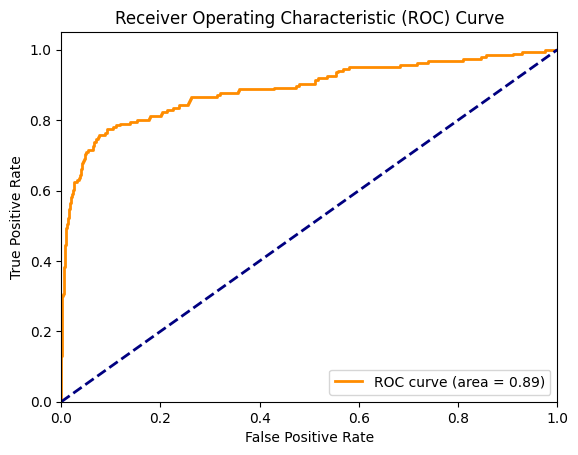

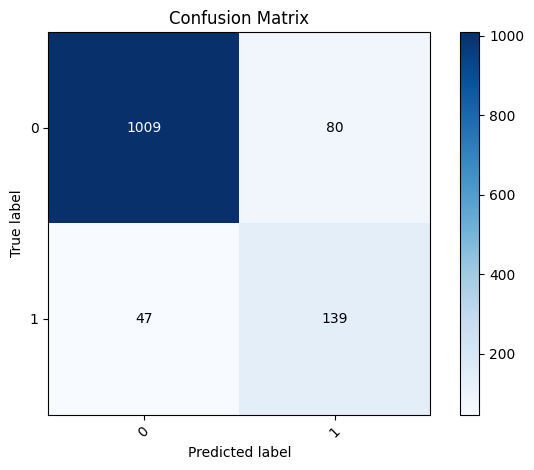

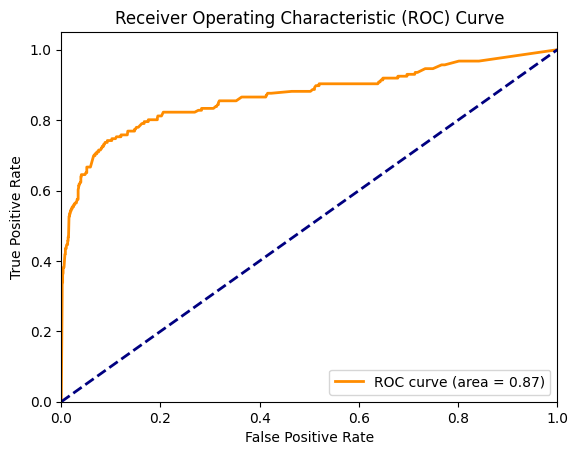

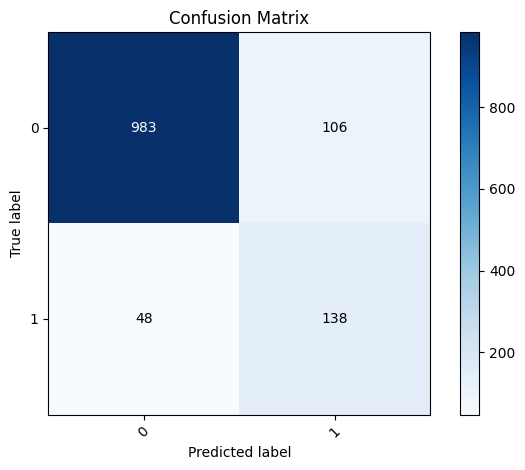

In [36]:
best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=10,
    trials=Trials()
)

In [37]:
import mlflow
best_result['max_features'] = 1
experiment_name = "optimized model"
run_name="Random_Search_CV_Tuned_Model"
model_tuned = RandomForestClassifier(**best_result)
model_tuned.fit(X_train, y_train)
run_params = best_result

y_pred = predict_on_test_data(model_tuned,X_test) #will return the predicted class
y_pred_prob = predict_prob_on_test_data(model_tuned,X_test) #model.predict_proba(X_test)
run_metrics = get_metrics(y_test, y_pred, y_pred_prob)
best_result

c:\Users\Admin\.conda\envs\lungscv\lib\site-packages\sklearn\utils\_param_validation.py:594: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(


InvalidParameterError: The 'min_samples_split' parameter of RandomForestClassifier must be an int in the range [2, inf) or a float in the range (0.0, 1.0]. Got 0 instead.

In [123]:
create_experiment(experiment_name,run_name,run_metrics,model_tuned,'confusion_matrix.png', 'roc_auc_curve.png',best_result)

2024/05/17 03:55:29 INFO mlflow.tracking.fluent: Experiment with name 'optimized model' does not exist. Creating a new experiment.


Run - Random_Search_CV_Tuned_Model is logged to Experiment - optimized model
